<a href="https://colab.research.google.com/github/yaiza612/Big_data/blob/main/LinearRegression_YaizaAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Linear regression consulting project by Yaiza Arnáiz Alcácer

In [1]:
SPARK_VERSION = '3.4.0'
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.osuosl.org/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!tar xf spark-3.4.0-bin-hadoop3.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.0-bin-hadoop3"
os.environ["SPARK_VERSION"] = '3.4.0'
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[*]").getOrCreate()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = spark.read.options(header='True', inferSchema='True').csv('/content/drive/MyDrive/Colab_Notebooks/cruise_ship_info.csv')
df.registerTempTable('data')

/content/spark-3.4.0-bin-hadoop3/python/pyspark/sql/dataframe.py:330: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn("Deprecated in 2.0, use createOrReplaceTempView instead.", FutureWarning)


In [5]:
df.printSchema()

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [6]:
from pyspark.ml.feature import StringIndexer

In [7]:
cruise_line_indexer = StringIndexer(inputCol="Cruise_line", outputCol="Cruise_line_Index")
df1= cruise_line_indexer.fit(df).transform(df)
df1.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-----------------+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|Cruise_line_Index|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+-----------------+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|             16.0|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|             16.0|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|              1.0|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|              1.0|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|              1.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|       

In [8]:
df1.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Ship_name,158,Infinity,None,Adventure,Zuiderdam
Cruise_line,158,None,None,Azamara,Windstar
Age,158,15.689873417721518,7.615691058751413,4,48
Tonnage,158,71.28467088607599,37.229540025907866,2.329,220.0
passengers,158,18.45740506329114,9.677094775143416,0.66,54.0
length,158,8.130632911392404,1.793473548054825,2.79,11.82
cabins,158,8.830000000000005,4.4714172221480615,0.33,27.0
passenger_density,158,39.90094936708861,8.63921711391542,17.7,71.43
crew,158,7.794177215189873,3.503486564627034,0.59,21.0


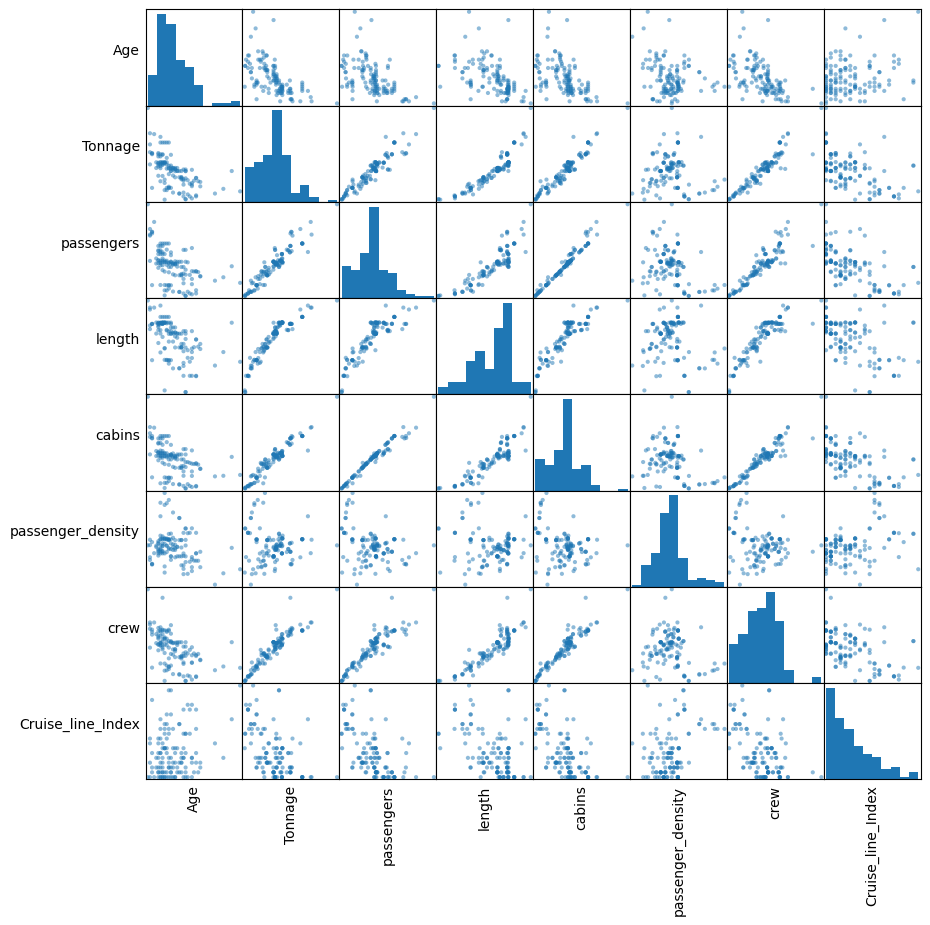

In [9]:
import pandas as pd
from pandas.plotting import scatter_matrix
numeric_features = [t[0] for t in df1.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = df1.select(numeric_features).sample(False, 0.8).toPandas()
axs = scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

As we can observe in the plotting, the crew seems to be related to the tonnage, passengers, length and number of cabins in a positive way. With the cruise line and the passenger density doesn't seem to be related.  Still I will calculate the correlation to check numerically what it is happening.

In [10]:
import six
for i in df1.columns:
    if not( isinstance(df1.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to crew for ", i, df1.stat.corr('crew',i))

Correlation to crew for  Age -0.5306565039638852
Correlation to crew for  Tonnage 0.927568811544939
Correlation to crew for  passengers 0.9152341306065384
Correlation to crew for  length 0.8958566271016579
Correlation to crew for  cabins 0.9508226063578497
Correlation to crew for  passenger_density -0.15550928421699717
Correlation to crew for  crew 1.0
Correlation to crew for  Cruise_line_Index -0.5154627327113319


According to the values of correlation, we can observe a stronger correlation between the cree and the tonnage, passengers, length, and number of cabins. 
For the cruise line, the passenger density and the age of the ships the correlation is negative. When the value of correlation is near to 0, there is no a linear regression, more close to 1, there are a stronger relation. As we can see, for passenger_density doesn't exist a linear regression. 


These two methods, the plotting and the value of correlation are methods that you can not use with a dataframe of terabytes, nevertheless, you could take a random small portion of the data to do the same analysis, I just perform and see more or less the relation that exist between the different variables.


Now, I will do the linear regression with all the variables.

In [11]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['Age', 'Tonnage', 'passengers', 'length', 'cabins', 'passenger_density', 'Cruise_line_Index'], outputCol = 'features')
crew_df1 = vectorAssembler.transform(df1)
crew_df1 = crew_df1.select(['features', 'crew'])
crew_df1.show(3)

+--------------------+----+
|            features|crew|
+--------------------+----+
|[6.0,30.276999999...|3.55|
|[6.0,30.276999999...|3.55|
|[26.0,47.262,14.8...| 6.7|
+--------------------+----+
only showing top 3 rows



In [12]:
train_data, test_data = crew_df1.randomSplit([0.7, 0.3])

In [13]:
train_data.describe().toPandas()

,summary,crew
0,count,99
1,mean,7.209494949494958
2,stddev,3.490568743125459
3,min,0.59
4,max,21.0


In [14]:
test_data.describe().toPandas()

,summary,crew
0,count,59
1,mean,8.775254237288136
2,stddev,3.328075635295715
3,min,1.46
4,max,19.1


In [15]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(labelCol='crew')

In [16]:
lr_model = lr.fit(train_data)

In [17]:
test_results = lr_model.evaluate(test_data)

In [18]:
test_results.residuals.show()

+--------------------+
|           residuals|
+--------------------+
|  -1.169843707440691|
|  0.2949523991168057|
| -0.3733191096996098|
| -1.2965959114786916|
|  0.6927671761342467|
| -0.5561299759359457|
| -1.0282589715188841|
| -0.4223171682257547|
| -0.4183821376468959|
|   1.046292489534192|
|-0.06048889959482...|
|  0.6204674969083239|
|   0.871298604532031|
| -0.5758780167546202|
|-0.29516406324495037|
|   1.191375752647426|
| -0.2714054136778046|
|-0.40327665423593473|
|-0.28018290936904755|
| -0.9736140633540629|
+--------------------+
only showing top 20 rows



In [19]:
test_results.rootMeanSquaredError

1.2939783851198476

In [20]:
test_results.r2


0.8462228929653667

So R squared at 0.91 indicates that in our model, approximate 91% of the variability in crew can be explained using this model.

In [21]:
predictions = lr_model.transform(test_data)

In [22]:
predictions.show()

+--------------------+-----+------------------+
|            features| crew|        prediction|
+--------------------+-----+------------------+
|[5.0,86.0,21.04,9...|  8.0| 9.169843707440691|
|[5.0,115.0,35.74,...| 12.2|11.905047600883194|
|[5.0,122.0,28.5,1...|  6.7|  7.07331910969961|
|[5.0,160.0,36.34,...| 13.6|14.896595911478691|
|[6.0,93.0,23.94,9...|11.09|10.397232823865753|
|[6.0,112.0,38.0,9...| 10.9|11.456129975935946|
|[7.0,89.6,25.5,9....| 9.87|10.898258971518883|
|[7.0,116.0,31.0,9...| 12.0|12.422317168225755|
|[7.0,158.0,43.7,1...| 13.6|14.018382137646896|
|[8.0,91.0,22.44,9...| 11.0| 9.953707510465808|
|[9.0,59.058,17.0,...|  7.4| 7.460488899594828|
|[9.0,81.0,21.44,9...| 10.0| 9.379532503091676|
|[9.0,88.5,21.24,9...| 10.3|  9.42870139546797|
|[9.0,90.09,25.01,...| 8.69|  9.26587801675462|
|[9.0,110.0,29.74,...| 11.6| 11.89516406324495|
|[9.0,113.0,26.74,...|12.38|11.188624247352575|
|[10.0,81.76899999...| 8.42| 8.691405413677805|
|[10.0,105.0,27.2,...|10.68|11.083276654

In [23]:
from  pyspark.sql.functions import abs
x =((predictions.crew -predictions.prediction)/predictions.crew)*100
predictions = predictions.withColumn('Accuracy',abs(x))
predictions.select("prediction","crew","Accuracy","features").show()

+------------------+-----+------------------+--------------------+
|        prediction| crew|          Accuracy|            features|
+------------------+-----+------------------+--------------------+
| 9.169843707440691|  8.0|14.623046343008639|[5.0,86.0,21.04,9...|
|11.905047600883194| 12.2|2.4176426157115225|[5.0,115.0,35.74,...|
|  7.07331910969961|  6.7| 5.571927010441937|[5.0,122.0,28.5,1...|
|14.896595911478691| 13.6| 9.533793466755085|[5.0,160.0,36.34,...|
|10.397232823865753|11.09|6.2467734547722875|[6.0,93.0,23.94,9...|
|11.456129975935946| 10.9| 5.102109870971979|[6.0,112.0,38.0,9...|
|10.898258971518883| 9.87|10.418024027546952|[7.0,89.6,25.5,9....|
|12.422317168225755| 12.0|3.5193097352146228|[7.0,116.0,31.0,9...|
|14.018382137646896| 13.6|3.0763392474036464|[7.0,158.0,43.7,1...|
| 9.953707510465808| 11.0| 9.511749904856291|[8.0,91.0,22.44,9...|
| 7.460488899594828|  7.4|0.8174175620922621|[9.0,59.058,17.0,...|
| 9.379532503091676| 10.0| 6.204674969083239|[9.0,81.0,21.44,9

In [24]:
unlabeled_data = test_data.select('features')

In [25]:
unlabeled_data.show()

+--------------------+
|            features|
+--------------------+
|[5.0,86.0,21.04,9...|
|[5.0,115.0,35.74,...|
|[5.0,122.0,28.5,1...|
|[5.0,160.0,36.34,...|
|[6.0,93.0,23.94,9...|
|[6.0,112.0,38.0,9...|
|[7.0,89.6,25.5,9....|
|[7.0,116.0,31.0,9...|
|[7.0,158.0,43.7,1...|
|[8.0,91.0,22.44,9...|
|[9.0,59.058,17.0,...|
|[9.0,81.0,21.44,9...|
|[9.0,88.5,21.24,9...|
|[9.0,90.09,25.01,...|
|[9.0,110.0,29.74,...|
|[9.0,113.0,26.74,...|
|[10.0,81.76899999...|
|[10.0,105.0,27.2,...|
|[10.0,110.0,29.74...|
|[10.0,138.0,31.14...|
+--------------------+
only showing top 20 rows



In [26]:
predictions = lr_model.transform(unlabeled_data)
predictions.show()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[5.0,86.0,21.04,9...| 9.169843707440691|
|[5.0,115.0,35.74,...|11.905047600883194|
|[5.0,122.0,28.5,1...|  7.07331910969961|
|[5.0,160.0,36.34,...|14.896595911478691|
|[6.0,93.0,23.94,9...|10.397232823865753|
|[6.0,112.0,38.0,9...|11.456129975935946|
|[7.0,89.6,25.5,9....|10.898258971518883|
|[7.0,116.0,31.0,9...|12.422317168225755|
|[7.0,158.0,43.7,1...|14.018382137646896|
|[8.0,91.0,22.44,9...| 9.953707510465808|
|[9.0,59.058,17.0,...| 7.460488899594828|
|[9.0,81.0,21.44,9...| 9.379532503091676|
|[9.0,88.5,21.24,9...|  9.42870139546797|
|[9.0,90.09,25.01,...|  9.26587801675462|
|[9.0,110.0,29.74,...| 11.89516406324495|
|[9.0,113.0,26.74,...|11.188624247352575|
|[10.0,81.76899999...| 8.691405413677805|
|[10.0,105.0,27.2,...|11.083276654235934|
|[10.0,110.0,29.74...|11.880182909369047|
|[10.0,138.0,31.14...|12.823614063354063|
+--------------------+------------

The results are pretty good, but now I want to do the linear regression only with the features that show a good relationship and compare with the model before.


In [27]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['Tonnage', 'passengers', 'length', 'cabins'], outputCol = 'features')
crew_df1 = vectorAssembler.transform(df1)
crew_df1 = crew_df1.select(['features', 'crew'])
crew_df1.show(3)

+--------------------+----+
|            features|crew|
+--------------------+----+
|[30.2769999999999...|3.55|
|[30.2769999999999...|3.55|
|[47.262,14.86,7.2...| 6.7|
+--------------------+----+
only showing top 3 rows



In [28]:
train_data, test_data = crew_df1.randomSplit([0.7, 0.3])

In [29]:
train_data.describe().toPandas()

,summary,crew
0,count,109
1,mean,7.779541284403672
2,stddev,3.71886018612262
3,min,0.59
4,max,21.0


In [30]:
test_data.describe().toPandas()

,summary,crew
0,count,49
1,mean,7.826734693877552
2,stddev,3.004777021507518
3,min,1.46
4,max,13.6


In [31]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(labelCol='crew')

In [32]:

lr_model = lr.fit(train_data)

In [33]:
test_results = lr_model.evaluate(test_data)

In [34]:
test_results.residuals.show()

+--------------------+
|           residuals|
+--------------------+
| 0.17487438115028286|
| -0.1036410652831119|
| -0.4226527053476552|
|0.010963101863624924|
| 0.31136391739106006|
| 0.31136391739106006|
|-0.22429120124936652|
| 0.09090575455519145|
|-0.04942644794329176|
| -0.5613586635422161|
| 0.26519022146860305|
|  0.2731666044806831|
|-0.06190155005185982|
| -1.1099527009097558|
|-0.23124226446475138|
| -0.6997295575064681|
| -0.4534873797769965|
| 0.42878463829387936|
| 0.07950227347181116|
|0.008838164588327757|
+--------------------+
only showing top 20 rows



In [35]:
test_results.rootMeanSquaredError

0.8600747980001288

In [36]:
test_results.r2

0.9163621639104963

Now our model explain the 88% of the variability of the data, so it is better keep all the variables to perform the model. However, the result didn't change too much because the main variables to explain the crew are the number of passengers, cabins and the tonnage and lenght of the ship. This make sense. Bigger is the ship, more is the number of people allowed to travel and more is the number of crew need it. 


In [37]:
predictions = lr_model.transform(test_data)
predictions.show()

+--------------------+----+------------------+
|            features|crew|        prediction|
+--------------------+----+------------------+
|[12.5,3.94,4.36,0...|1.46| 1.285125618849717|
|[16.8,2.96,5.14,1...| 2.1| 2.203641065283112|
|[22.08,8.26,5.78,...| 3.5| 3.922652705347655|
|[25.0,3.88,5.97,1...|2.87| 2.859036898136375|
|[30.2769999999999...| 4.0|  3.68863608260894|
|[30.2769999999999...| 4.0|  3.68863608260894|
|[30.2769999999999...|3.55|3.7742912012493663|
| [33.0,4.9,5.6,2.45]|3.24|3.1490942454448088|
|[34.25,10.52,6.15...| 4.7| 4.749426447943292|
|[44.348,12.0,7.54...| 5.2| 5.761358663542216|
|[46.052,14.52,7.2...| 6.6| 6.334809778531397|
|[47.262,14.86,7.2...| 6.7| 6.426833395519317|
|[50.0,7.0,7.09,3.54]|4.45|  4.51190155005186|
|[50.76,17.48,7.54...|6.14|7.2499527009097555|
|[53.049,13.44,7.2...| 6.0| 6.231242264464751|
|[53.872,14.94,7.9...|6.12| 6.819729557506468|
|[55.451,12.64,7.1...|5.57| 6.023487379776997|
|[58.6,15.66,8.23,...| 7.6|  7.17121536170612|
|[59.058,17.0

In [38]:
from  pyspark.sql.functions import abs
x =((predictions.crew -predictions.prediction)/predictions.crew)*100
predictions = predictions.withColumn('Accuracy',abs(x))
predictions.select("prediction","crew","Accuracy","features").show()

+------------------+----+-------------------+--------------------+
|        prediction|crew|           Accuracy|            features|
+------------------+----+-------------------+--------------------+
| 1.285125618849717|1.46| 11.977697339060471|[12.5,3.94,4.36,0...|
| 2.203641065283112| 2.1|  4.935288823005329|[16.8,2.96,5.14,1...|
| 3.922652705347655| 3.5| 12.075791581361576|[22.08,8.26,5.78,...|
| 2.859036898136375|2.87|0.38198961197299386|[25.0,3.88,5.97,1...|
|  3.68863608260894| 4.0|  7.784097934776502|[30.2769999999999...|
|  3.68863608260894| 4.0|  7.784097934776502|[30.2769999999999...|
|3.7742912012493663|3.55|   6.31806200702441|[30.2769999999999...|
|3.1490942454448088|3.24| 2.8057331652836868| [33.0,4.9,5.6,2.45]|
| 4.749426447943292| 4.7|  1.051626551984931|[34.25,10.52,6.15...|
| 5.761358663542216| 5.2| 10.795358914273386|[44.348,12.0,7.54...|
| 6.334809778531397| 6.6|  4.018033658615198|[46.052,14.52,7.2...|
| 6.426833395519317| 6.7|  4.077113499711688|[47.262,14.86,7.2

In [39]:
unlabeled_data = test_data.select('features')
unlabeled_data.show()

+--------------------+
|            features|
+--------------------+
|[12.5,3.94,4.36,0...|
|[16.8,2.96,5.14,1...|
|[22.08,8.26,5.78,...|
|[25.0,3.88,5.97,1...|
|[30.2769999999999...|
|[30.2769999999999...|
|[30.2769999999999...|
| [33.0,4.9,5.6,2.45]|
|[34.25,10.52,6.15...|
|[44.348,12.0,7.54...|
|[46.052,14.52,7.2...|
|[47.262,14.86,7.2...|
|[50.0,7.0,7.09,3.54]|
|[50.76,17.48,7.54...|
|[53.049,13.44,7.2...|
|[53.872,14.94,7.9...|
|[55.451,12.64,7.1...|
|[58.6,15.66,8.23,...|
|[59.058,17.0,7.63...|
|[59.652,13.2,7.77...|
+--------------------+
only showing top 20 rows



In [40]:
predictions = lr_model.transform(unlabeled_data)
predictions.show()

+--------------------+------------------+
|            features|        prediction|
+--------------------+------------------+
|[12.5,3.94,4.36,0...| 1.285125618849717|
|[16.8,2.96,5.14,1...| 2.203641065283112|
|[22.08,8.26,5.78,...| 3.922652705347655|
|[25.0,3.88,5.97,1...| 2.859036898136375|
|[30.2769999999999...|  3.68863608260894|
|[30.2769999999999...|  3.68863608260894|
|[30.2769999999999...|3.7742912012493663|
| [33.0,4.9,5.6,2.45]|3.1490942454448088|
|[34.25,10.52,6.15...| 4.749426447943292|
|[44.348,12.0,7.54...| 5.761358663542216|
|[46.052,14.52,7.2...| 6.334809778531397|
|[47.262,14.86,7.2...| 6.426833395519317|
|[50.0,7.0,7.09,3.54]|  4.51190155005186|
|[50.76,17.48,7.54...|7.2499527009097555|
|[53.049,13.44,7.2...| 6.231242264464751|
|[53.872,14.94,7.9...| 6.819729557506468|
|[55.451,12.64,7.1...| 6.023487379776997|
|[58.6,15.66,8.23,...|  7.17121536170612|
|[59.058,17.0,7.63...| 7.320497726528189|
|[59.652,13.2,7.77...| 6.431161835411673|
+--------------------+------------